<a href="https://colab.research.google.com/github/Siarhei-Y/tea_recognition/blob/main/Tea_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

from tensorflow.keras import layers

### Upload data

In [2]:
path = r'/content/drive/MyDrive/Data/tea_recognition/img'
labels = pd.read_csv(r'/content/drive/MyDrive/Data/tea_recognition/train.csv')

In [ ]:
# labels.head()

In [3]:
data_dir = pathlib.Path(r'/content/drive/MyDrive/Data/tea_recognition/img/') 
data_dir

PosixPath('/content/drive/MyDrive/Data/tea_recognition/img')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3534


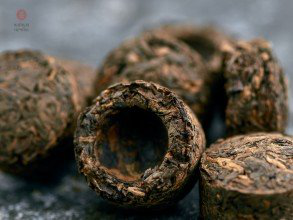

In [5]:
shu = list(data_dir.glob('shu_puerh/*'))
PIL.Image.open(str(shu[0]))

### Create a dataset

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [7]:
x_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    shuffle= True,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size= BATCH_SIZE)

Found 3549 files belonging to 8 classes.
Using 2840 files for training.


In [8]:
x_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3549 files belonging to 8 classes.
Using 709 files for validation.


In [9]:
classes = x_train.class_names
print(classes)

['black_tea', 'green_tea', 'phoenix-oolong', 'sheng_puerh', 'shu_puerh', 'south_fujian', 'taiwanese_oolong', 'wyui_oolong']


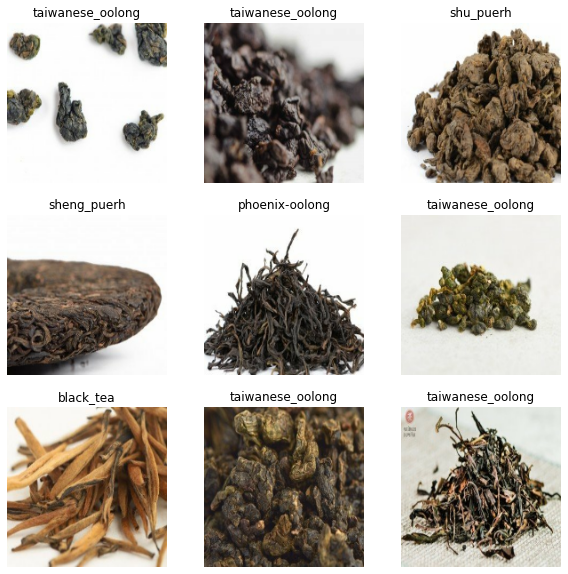

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in x_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

In [ ]:
for img_batch , labels_batch in x_train:
  print(img_batch.shape)
  print(labels_batch.shape)
  break

(8, 180, 180, 3)
(8,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

x_train = x_train.cache().prefetch(buffer_size=AUTOTUNE)
x_val = x_val.cache().prefetch(buffer_size=AUTOTUNE)

### Train a Baseline


In [10]:
K = len(classes)
EPOCHS = 15 

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
r = model.fit(
  x_train,
  validation_data=x_val,
  epochs=EPOCHS
)

Epoch 1/15
89/89 [==============================] - 706s 8s/step - loss: 1.8181 - accuracy: 0.2880 - val_loss: 1.6257 - val_accuracy: 0.3554
Epoch 2/15
89/89 [==============================] - 2s 23ms/step - loss: 1.4621 - accuracy: 0.4317 - val_loss: 1.3727 - val_accuracy: 0.4528
Epoch 3/15
89/89 [==============================] - 2s 22ms/step - loss: 1.2727 - accuracy: 0.5155 - val_loss: 1.3839 - val_accuracy: 0.4697
Epoch 4/15
89/89 [==============================] - 2s 22ms/step - loss: 1.0906 - accuracy: 0.5958 - val_loss: 1.3934 - val_accuracy: 0.4640
Epoch 5/15
89/89 [==============================] - 2s 23ms/step - loss: 0.8565 - accuracy: 0.6894 - val_loss: 1.5155 - val_accuracy: 0.4810
Epoch 6/15
89/89 [==============================] - 2s 22ms/step - loss: 0.6480 - accuracy: 0.7754 - val_loss: 1.7869 - val_accuracy: 0.4866
Epoch 7/15
89/89 [==============================] - 2s 22ms/step - loss: 0.4949 - accuracy: 0.8292 - val_loss: 1.8977 - val_accuracy: 0.4556
Epoch 8/15
89

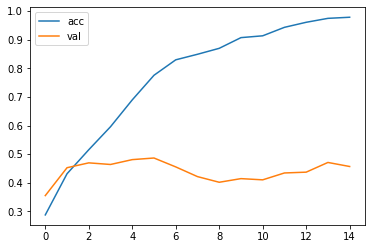

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val')
plt.legend()

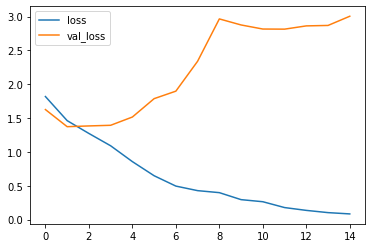

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

### Tuning
* Data augmentation 
* Dropout
* L2 L1 Reg


In [12]:
EPOCHS = 100 
LR = 0.001

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Epoch 1/100
89/89 [==============================] - 9s 86ms/step - loss: 1.9299 - accuracy: 0.2327 - val_loss: 1.8338 - val_accuracy: 0.2271
Epoch 2/100
89/89 [==============================] - 8s 85ms/step - loss: 1.7550 - accuracy: 0.3218 - val_loss: 1.8535 - val_accuracy: 0.2567
Epoch 3/100
89/89 [==============================] - 8s 84ms/step - loss: 1.5908 - accuracy: 0.3725 - val_loss: 1.5189 - val_accuracy: 0.3399
Epoch 4/100
89/89 [==============================] - 8s 85ms/step - loss: 1.4884 - accuracy: 0.4004 - val_loss: 1.5831 - val_accuracy: 0.3893
Epoch 5/100
89/89 [==============================] - 8s 85ms/step - loss: 1.4188 - accuracy: 0.4342 - val_loss: 1.4688 - val_accuracy: 0.4006
Epoch 6/100
89/89 [==============================] - 8s 86ms/step - loss: 1.3633 - accuracy: 0.4761 - val_loss: 1.3870 - val_accuracy: 0.4217
Epoch 7/100
89/89 [==============================] - 8s 86ms/step - loss: 1.3338 - accuracy: 0.4866 - val_loss: 1.5148 - val_accuracy: 0.3879
Epoch 

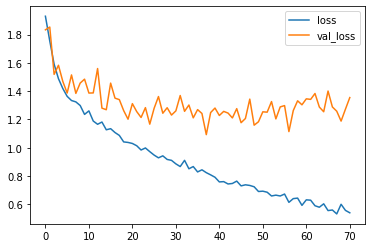

In [ ]:
r = model.fit(
  x_train,
  validation_data=x_val,
  epochs=EPOCHS,
  callbacks=[callback]
)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

### Experiments line #1

In [14]:
EPOCHS = 100 
LR = 0.001

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.5),
  ]
)

Epoch 1/100
89/89 [==============================] - 9s 91ms/step - loss: 1.9591 - accuracy: 0.2363 - val_loss: 1.9778 - val_accuracy: 0.2680
Epoch 2/100
89/89 [==============================] - 8s 90ms/step - loss: 1.9532 - accuracy: 0.2349 - val_loss: 2.0664 - val_accuracy: 0.2680
Epoch 3/100
89/89 [==============================] - 8s 88ms/step - loss: 1.9278 - accuracy: 0.2303 - val_loss: 1.8993 - val_accuracy: 0.1989
Epoch 4/100
89/89 [==============================] - 8s 88ms/step - loss: 1.8466 - accuracy: 0.2623 - val_loss: 1.8030 - val_accuracy: 0.2863
Epoch 5/100
89/89 [==============================] - 8s 89ms/step - loss: 1.8040 - accuracy: 0.2820 - val_loss: 1.8395 - val_accuracy: 0.2398
Epoch 6/100
89/89 [==============================] - 8s 89ms/step - loss: 1.7750 - accuracy: 0.3102 - val_loss: 1.8806 - val_accuracy: 0.2285
Epoch 7/100
89/89 [==============================] - 8s 89ms/step - loss: 1.7226 - accuracy: 0.3306 - val_loss: 1.8821 - val_accuracy: 0.2398
Epoch 

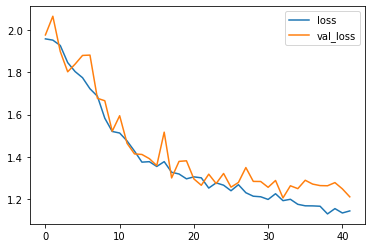

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(K)
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

r = model.fit(
  x_train,
  validation_data=x_val,
  epochs=EPOCHS,
  callbacks=[callback],
)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

###Experiments line #2

In [21]:
EPOCHS = 100 
LR = 0.001

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.5),
  ]
)

In [39]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, (3,3), strides=(1, 1), padding='same'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(K, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

r = model.fit(
  x_train,
  validation_data=x_val,
  epochs=EPOCHS,
  callbacks=[callback]
)

Epoch 1/100
89/89 [==============================] - 9s 88ms/step - loss: 1.9786 - accuracy: 0.2426 - val_loss: 2.0078 - val_accuracy: 0.2708
Epoch 2/100
89/89 [==============================] - 8s 85ms/step - loss: 1.8672 - accuracy: 0.2665 - val_loss: 1.7900 - val_accuracy: 0.2652
Epoch 3/100
89/89 [==============================] - 8s 85ms/step - loss: 1.7002 - accuracy: 0.3032 - val_loss: 1.6753 - val_accuracy: 0.3117
Epoch 4/100
89/89 [==============================] - 8s 87ms/step - loss: 1.5513 - accuracy: 0.3771 - val_loss: 1.6024 - val_accuracy: 0.3272
Epoch 5/100
89/89 [==============================] - 8s 88ms/step - loss: 1.5031 - accuracy: 0.3940 - val_loss: 1.5384 - val_accuracy: 0.3752
Epoch 6/100
89/89 [==============================] - 8s 87ms/step - loss: 1.4468 - accuracy: 0.4165 - val_loss: 1.3962 - val_accuracy: 0.4231
Epoch 7/100
89/89 [==============================] - 8s 87ms/step - loss: 1.4085 - accuracy: 0.4359 - val_loss: 1.4483 - val_accuracy: 0.4118
Epoch 

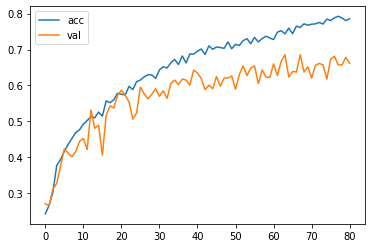

In [40]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val')
plt.legend()

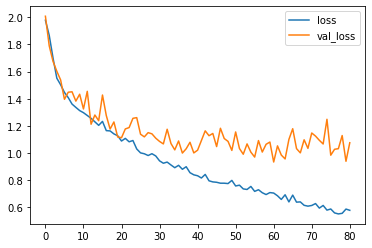

In [41]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [44]:
model.save('saved_model/my_model.h5')